# Use synthetic attention as input

Let's see the activations and attention maps for a model trained with the synthetic attention masks as inputs.

In [1]:
from PIL import Image
import os


test_data_root_dir = 'test_data/attention_t01_route00_clearnoon'

def open_image(img_name: str) -> Image.Image:
    img = Image.open(os.path.join(os.getcwd(), test_data_root_dir, img_name))
    if 'virtual_attention' in img_name:
        return img.convert('L')
    return img.convert('RGB')

img_paths_dict = {
    'rgb_central': [open_image('rgb_central000517.png')],
    'rgb_left': [open_image('rgb_left000517.png')],
    'rgb_right': [open_image('rgb_right000517.png')],
    'virtual_attention_central_': [open_image('virtual_attention_central_000517.jpg')],
    'virtual_attention_left_': [open_image('virtual_attention_left_000517.jpg')],
    'virtual_attention_right_': [open_image('virtual_attention_right_000517.jpg')],
}

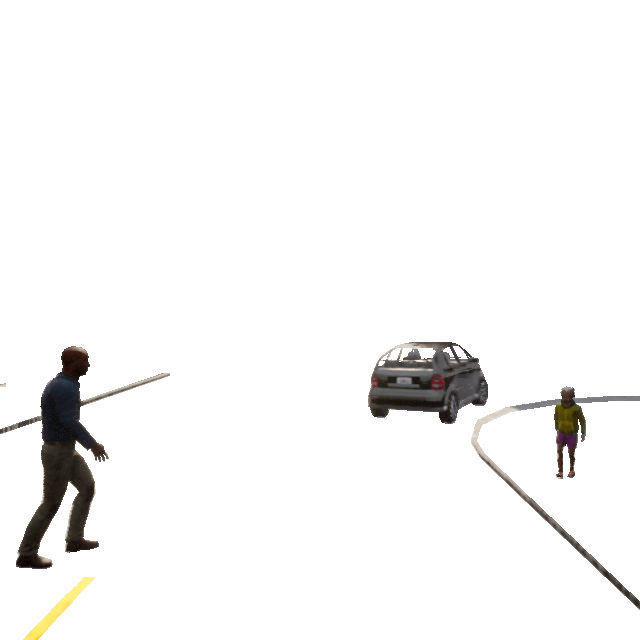

In [2]:
rgba_central = Image.new('RGBA', img_paths_dict['rgb_central'][0].size)

rgba_central.paste(img_paths_dict['rgb_central'][0], (0, 0))
rgba_central.putalpha(img_paths_dict['virtual_attention_central_'][0])

rgba_central

## Load the model

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from network.models.architectures.CIL_multiview.CIL_multiview import CIL_multiview
import os
import json
from configs import g_conf, set_type_of_process, merge_with_yaml
from _utils.training_utils import check_saved_checkpoints
import torch
from typing import OrderedDict
from PIL import Image
from einops import rearrange


os.environ["CUDA_VISIBLE_DEVICES"] = "5"

exp_batch = 'CILv2_attention'
exp_name = 'CILv2_3cam_Town01_8hdata_noAttentionLoss_AttAsInput_fromData'

merge_with_yaml(os.path.join('configs', exp_batch, f'{exp_name}.yaml'))
g_conf.PROCESS_NAME = 'train_val'
g_conf.DATASET_PATH = '/datafast/Datasets/dporres/CARLA'

os.environ['DATASET_PATH'] = g_conf.DATASET_PATH

model = CIL_multiview(g_conf.MODEL_CONFIGURATION)



latest_checkpoint = check_saved_checkpoints(
    os.path.join('/datafast/experiments/dporres/VisionTFM/',
                 '_results', g_conf.EXPERIMENT_BATCH_NAME, g_conf.EXPERIMENT_NAME, 'checkpoints'))

checkpoint = torch.load(latest_checkpoint)

new_state_dict = {}
for k, v in checkpoint['model'].items():
    new_state_dict[k[7:]] = v


new_state_dict = OrderedDict(new_state_dict)

model.load_state_dict(new_state_dict)

# load the data 
from dataloaders.transforms import canbus_normalization, train_transform

test_data_root_dir = 'test_data/attention_t01_route00_clearnoon'

def open_image(img_name: str) -> Image.Image:
    img = Image.open(os.path.join(os.getcwd(), test_data_root_dir, img_name))
    if 'virtual_attention' in img_name:
        return img.convert('L')
    return img.convert('RGB')

img_paths_dict = {
    'resized_rgb_central': [open_image('resized_rgb_central000517.png')],
    'resized_rgb_left': [open_image('resized_rgb_left000517.png')],
    'resized_rgb_right': [open_image('resized_rgb_right000517.png')],
    'virtual_attention_central_': [open_image('virtual_attention_central_000517.jpg')],
    'virtual_attention_left_': [open_image('virtual_attention_left_000517.jpg')],
    'virtual_attention_right_': [open_image('virtual_attention_right_000517.jpg')],
}

canbus_paths = [os.path.join(os.getcwd(), test_data_root_dir, 'cmd_fix_can_bus000517.json')]

full_dataset = []

for camera_type, img_paths in img_paths_dict.items():
    if len(img_paths) != len(canbus_paths):
        print(camera_type, len(img_paths), len(canbus_paths))
        raise RuntimeError('The numbers of images and canbus data are not mathced!!')

for i in range(len(canbus_paths)):
    datapoint = {}
    datapoint['can_bus'] = dict()
    f = open(canbus_paths[i], 'r')
    canbus_data = json.loads(f.read())
    for value in g_conf.TARGETS + g_conf.OTHER_INPUTS:
        datapoint['can_bus'][value] = canbus_data[value]
    datapoint['can_bus'] = canbus_normalization(datapoint['can_bus'], g_conf.DATA_NORMALIZATION)
    for camera_type, img_paths in img_paths_dict.items():
        datapoint[camera_type] = img_paths[i]
    full_dataset.append(datapoint)

data = train_transform(full_dataset[0], (3, 300, 300))

src_images = [data[camera_type] for camera_type in g_conf.DATA_USED if 'rgb' in camera_type]

# Append the synthetic attention to the each camera as an alpha channel
src_attn_masks = [data[camera_type] for camera_type in g_conf.DATA_USED if 'virtual_attention' in camera_type]
for i in range(len(src_images)):
    src_images[i] = torch.cat((src_images[i], src_attn_masks[i]), 0)

src_directions = [torch.tensor([data['can_bus']['direction']]).float()]
src_s = [torch.tensor([data['can_bus']['speed']]).float()]

x = torch.stack(src_images)
d = src_directions[-1]
s = src_s[-1]

e_p, resnet_inter = model.encoder_embedding_perception(x)

e_p = rearrange(e_p, 'b dim h w -> 1 (b h w) dim')

e_d = model.command(d).unsqueeze(1)
e_s = model.speed(s).unsqueeze(0).unsqueeze(0)

e_p = e_p + e_d + e_s
e_p = e_p + model.positional_encoding

in_memory, attn_weights = model.tx_encoder(e_p)

print(model.action_prediction(in_memory, 3))

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensor([[[-0.0012, -0.5469]]], grad_fn=<UnsqueezeBackward0>), None, None)


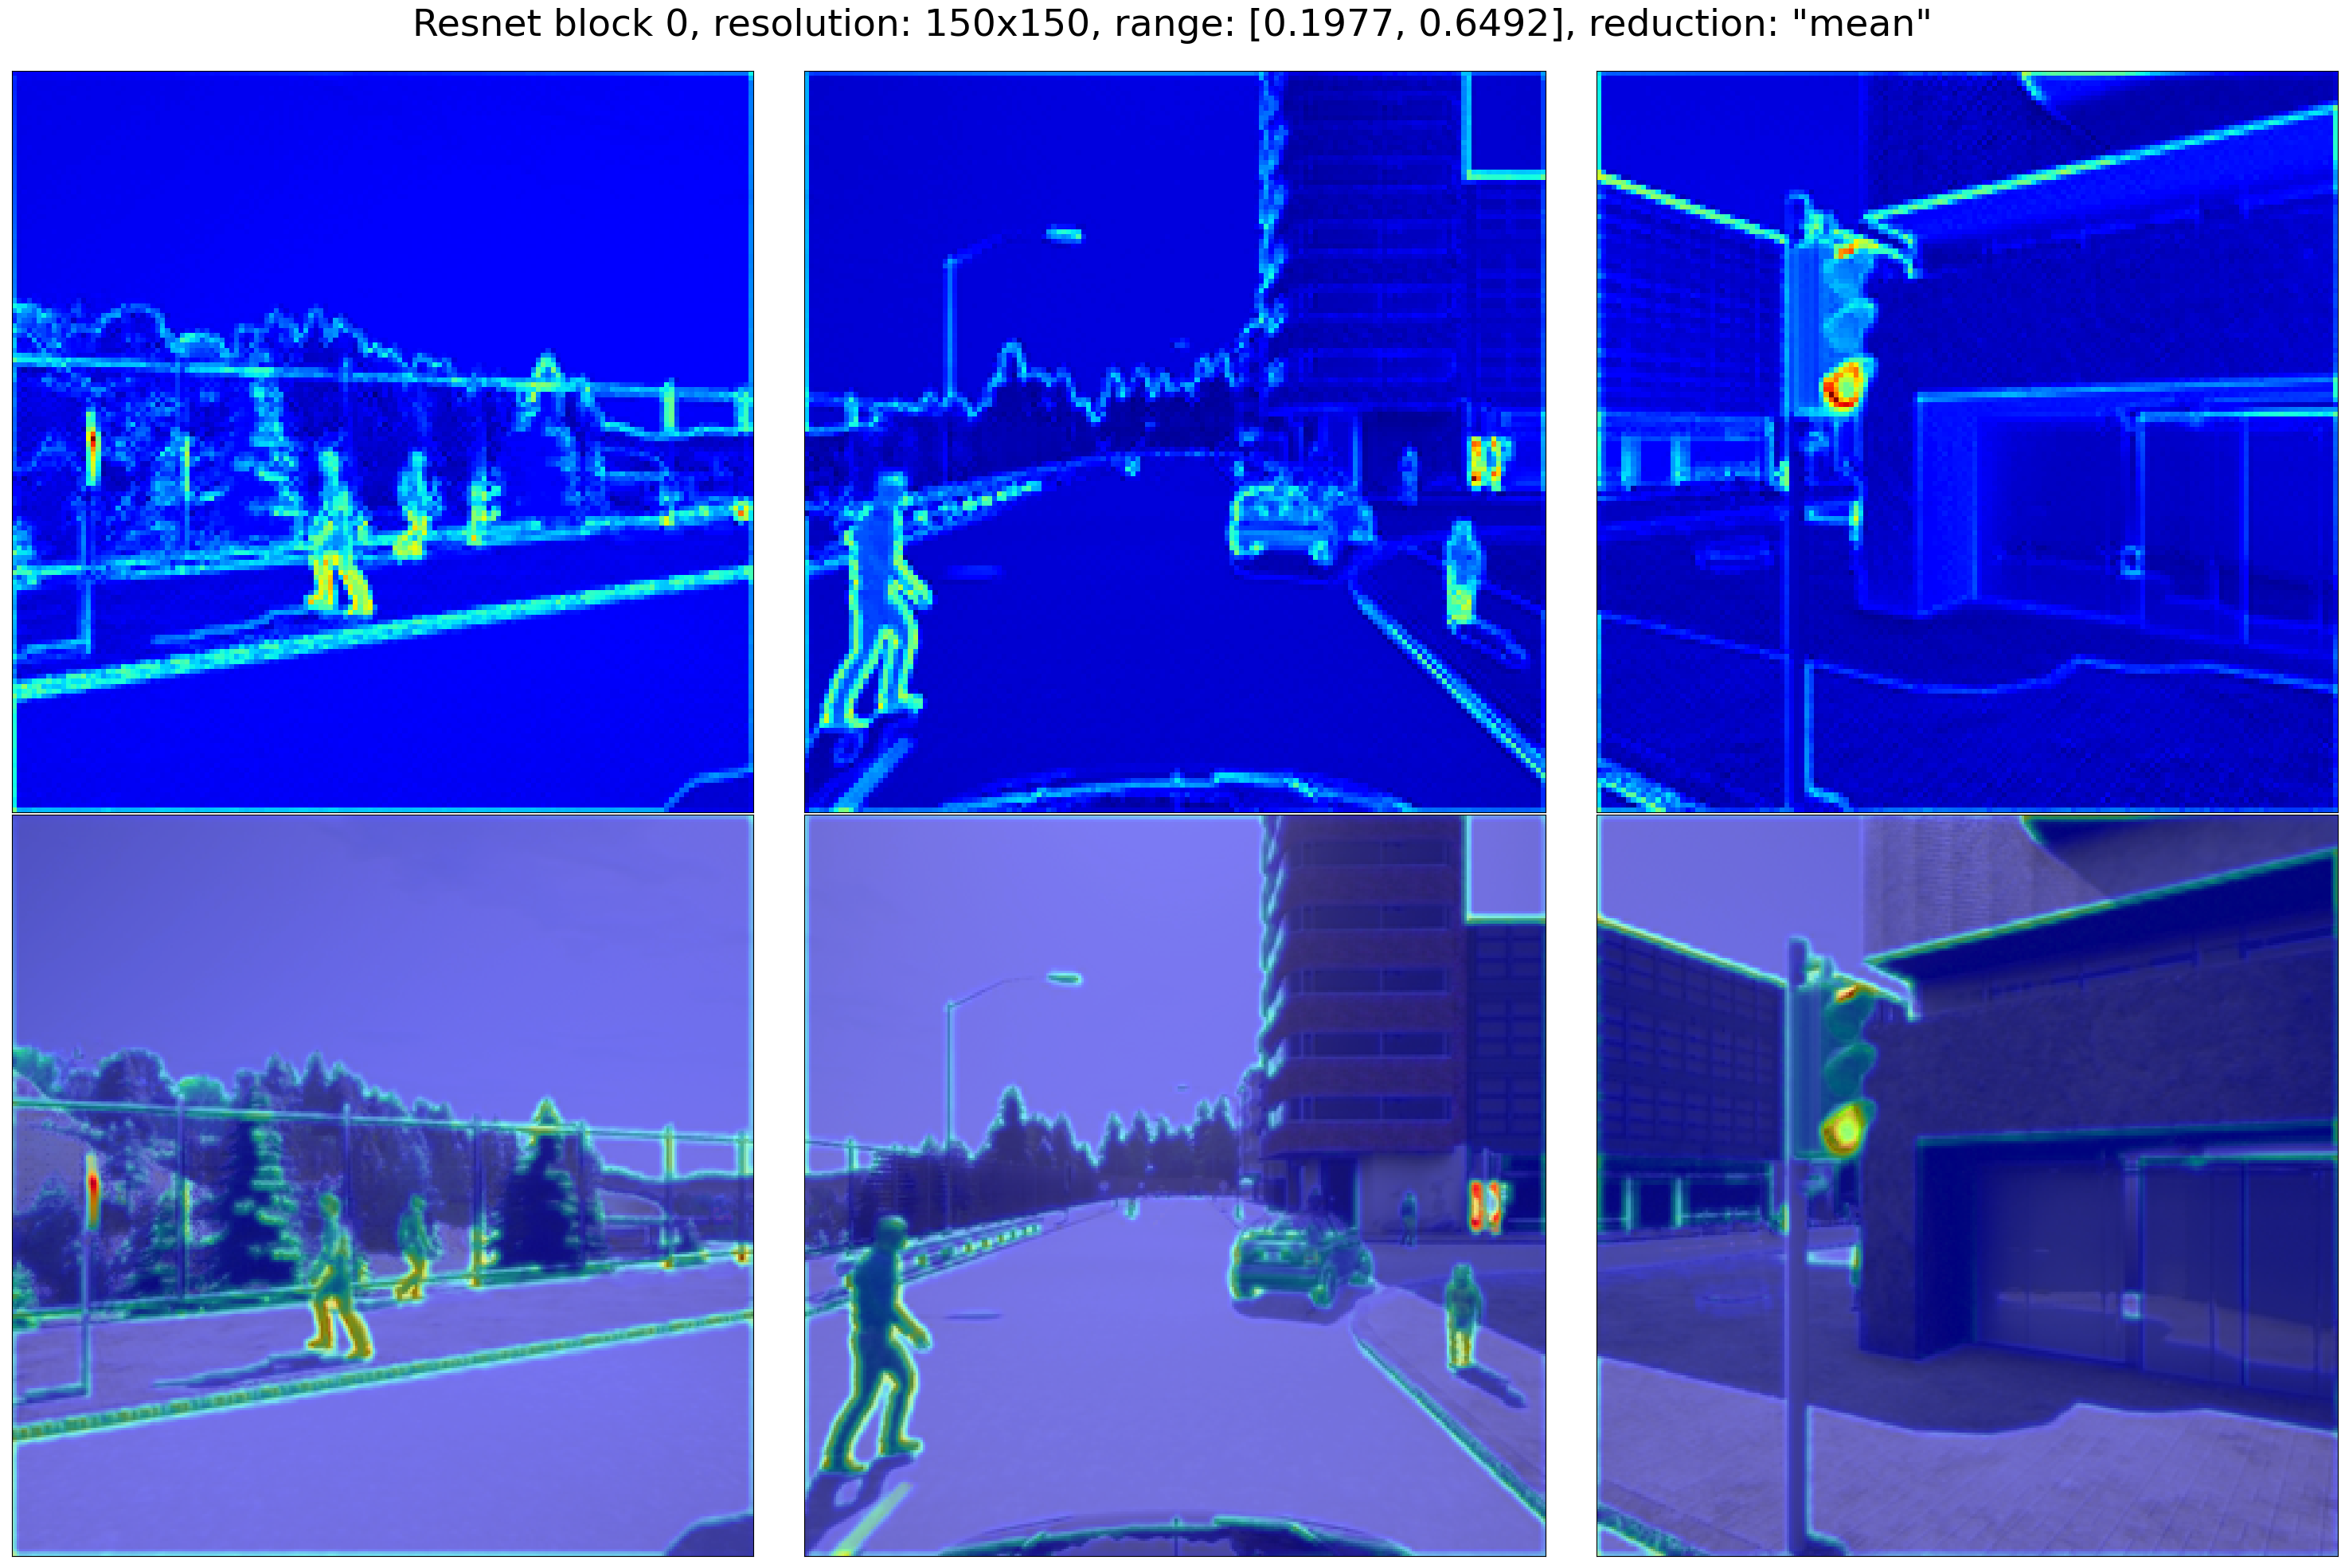

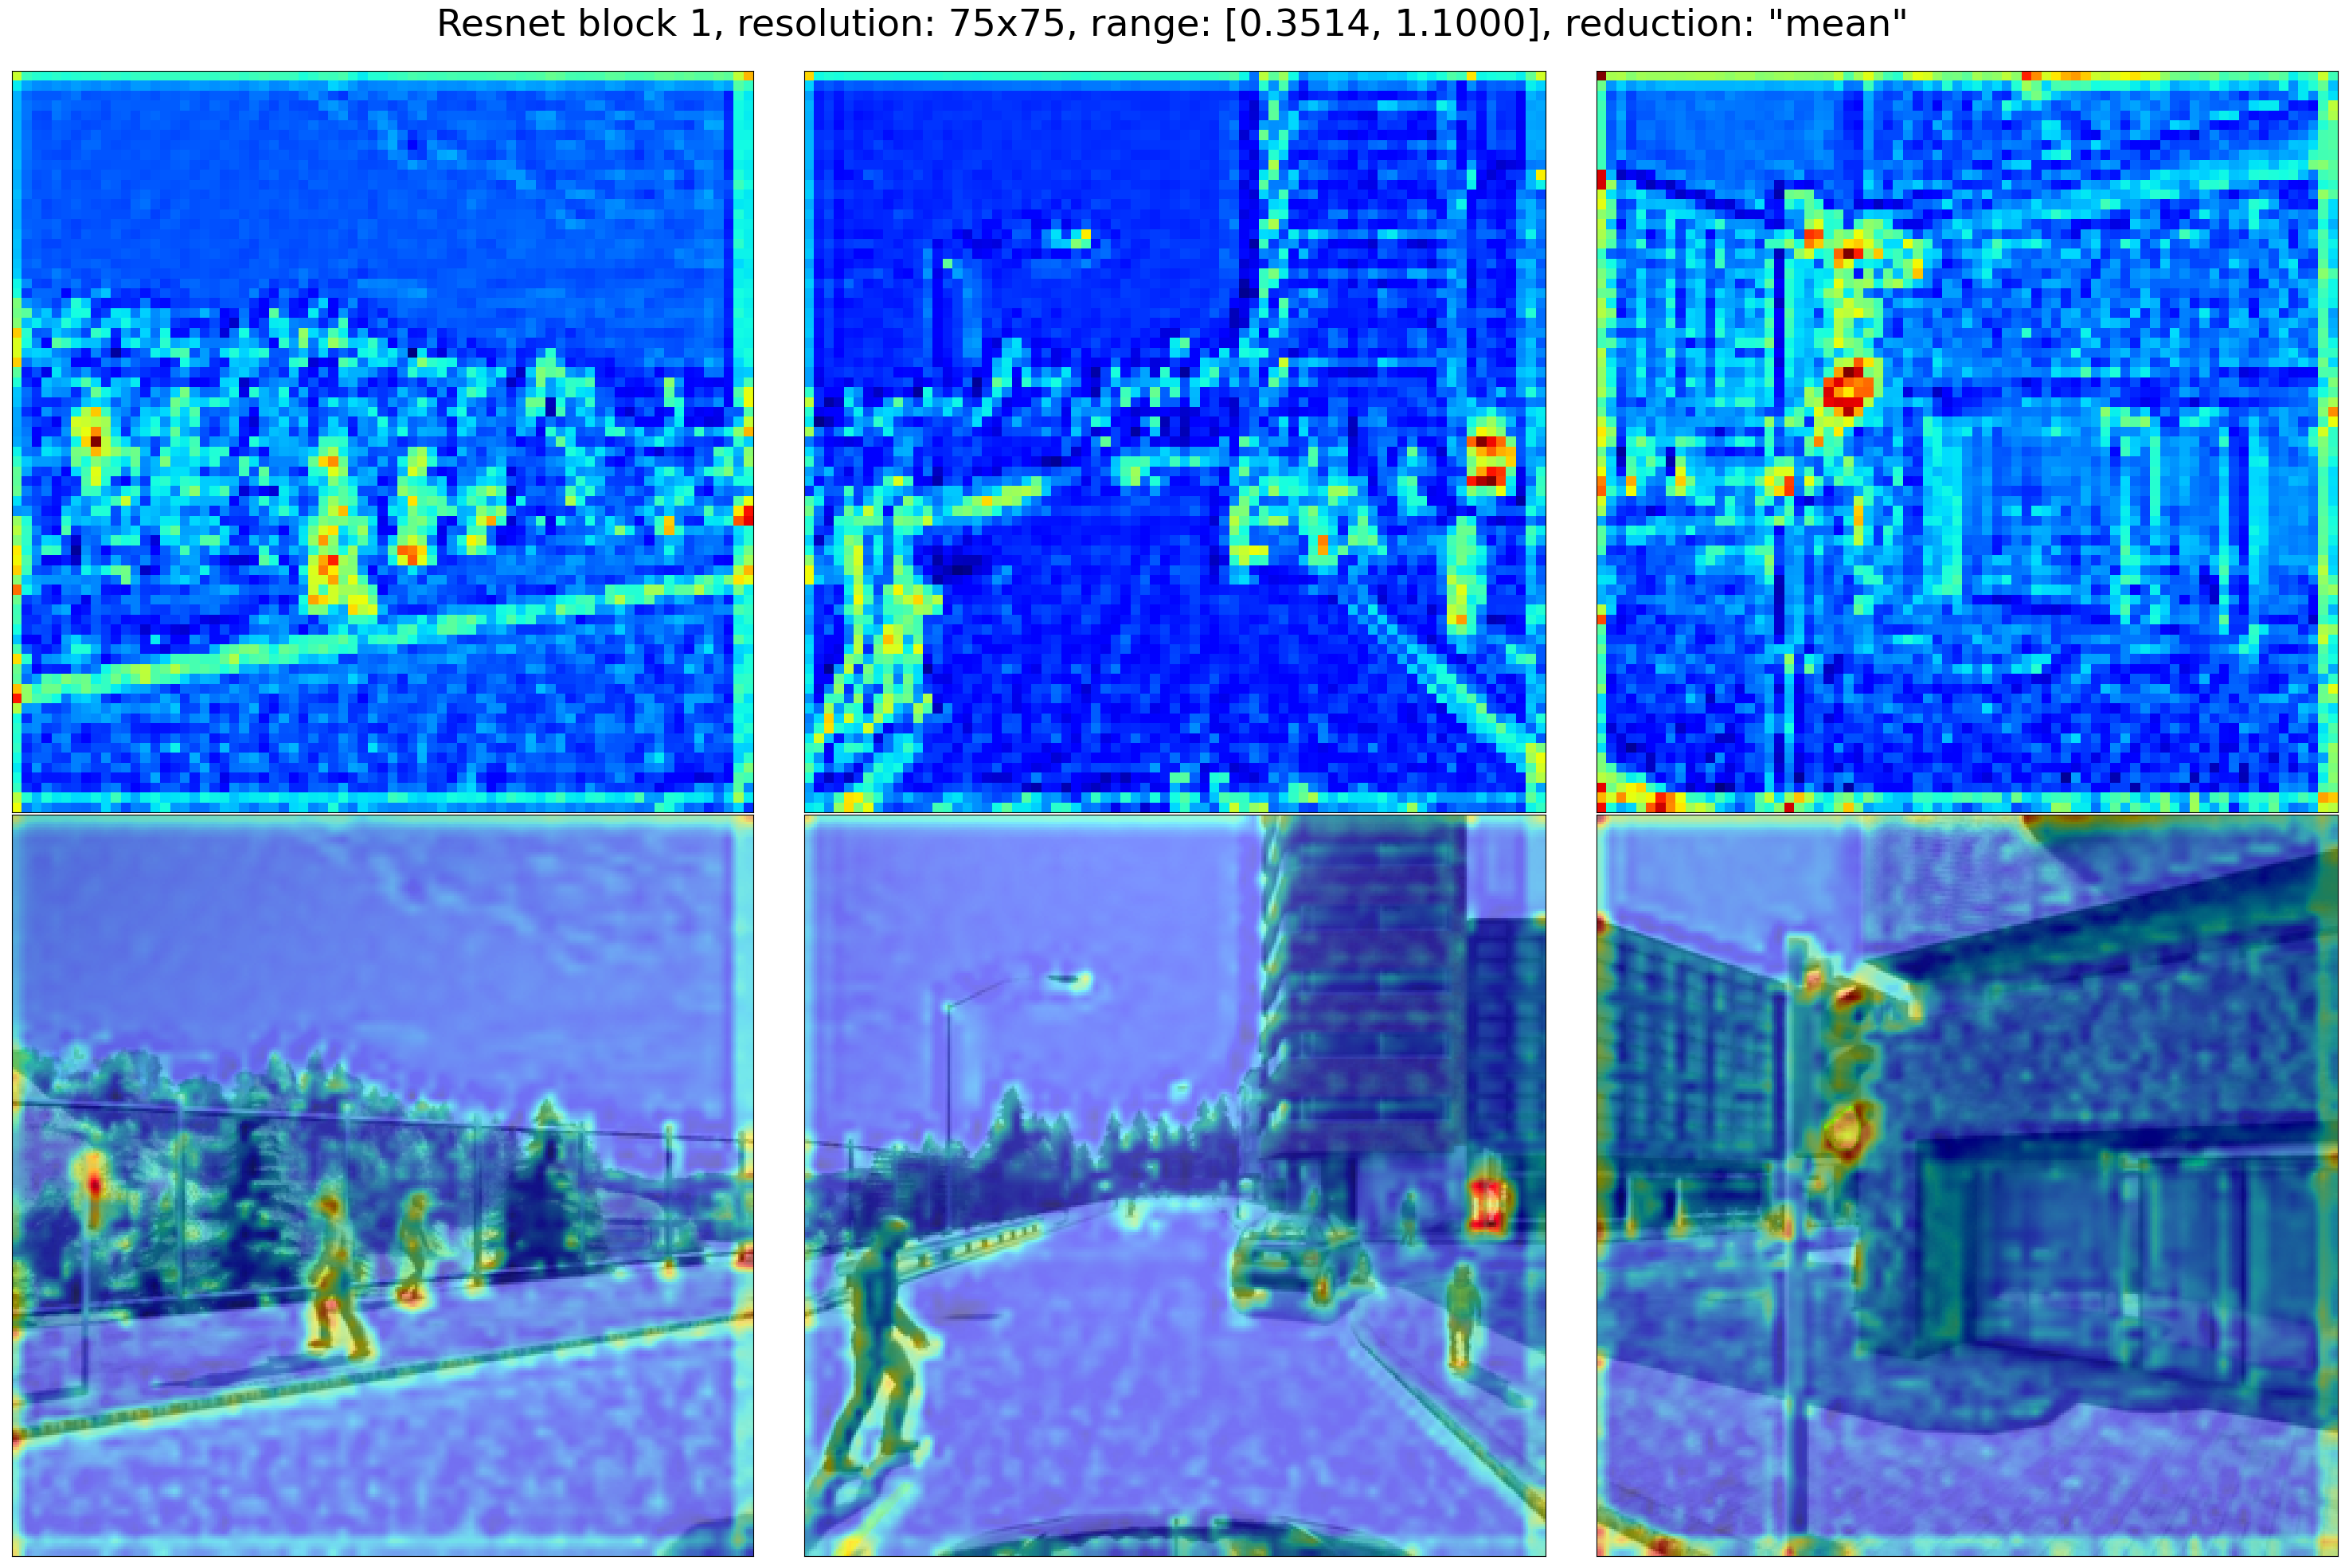

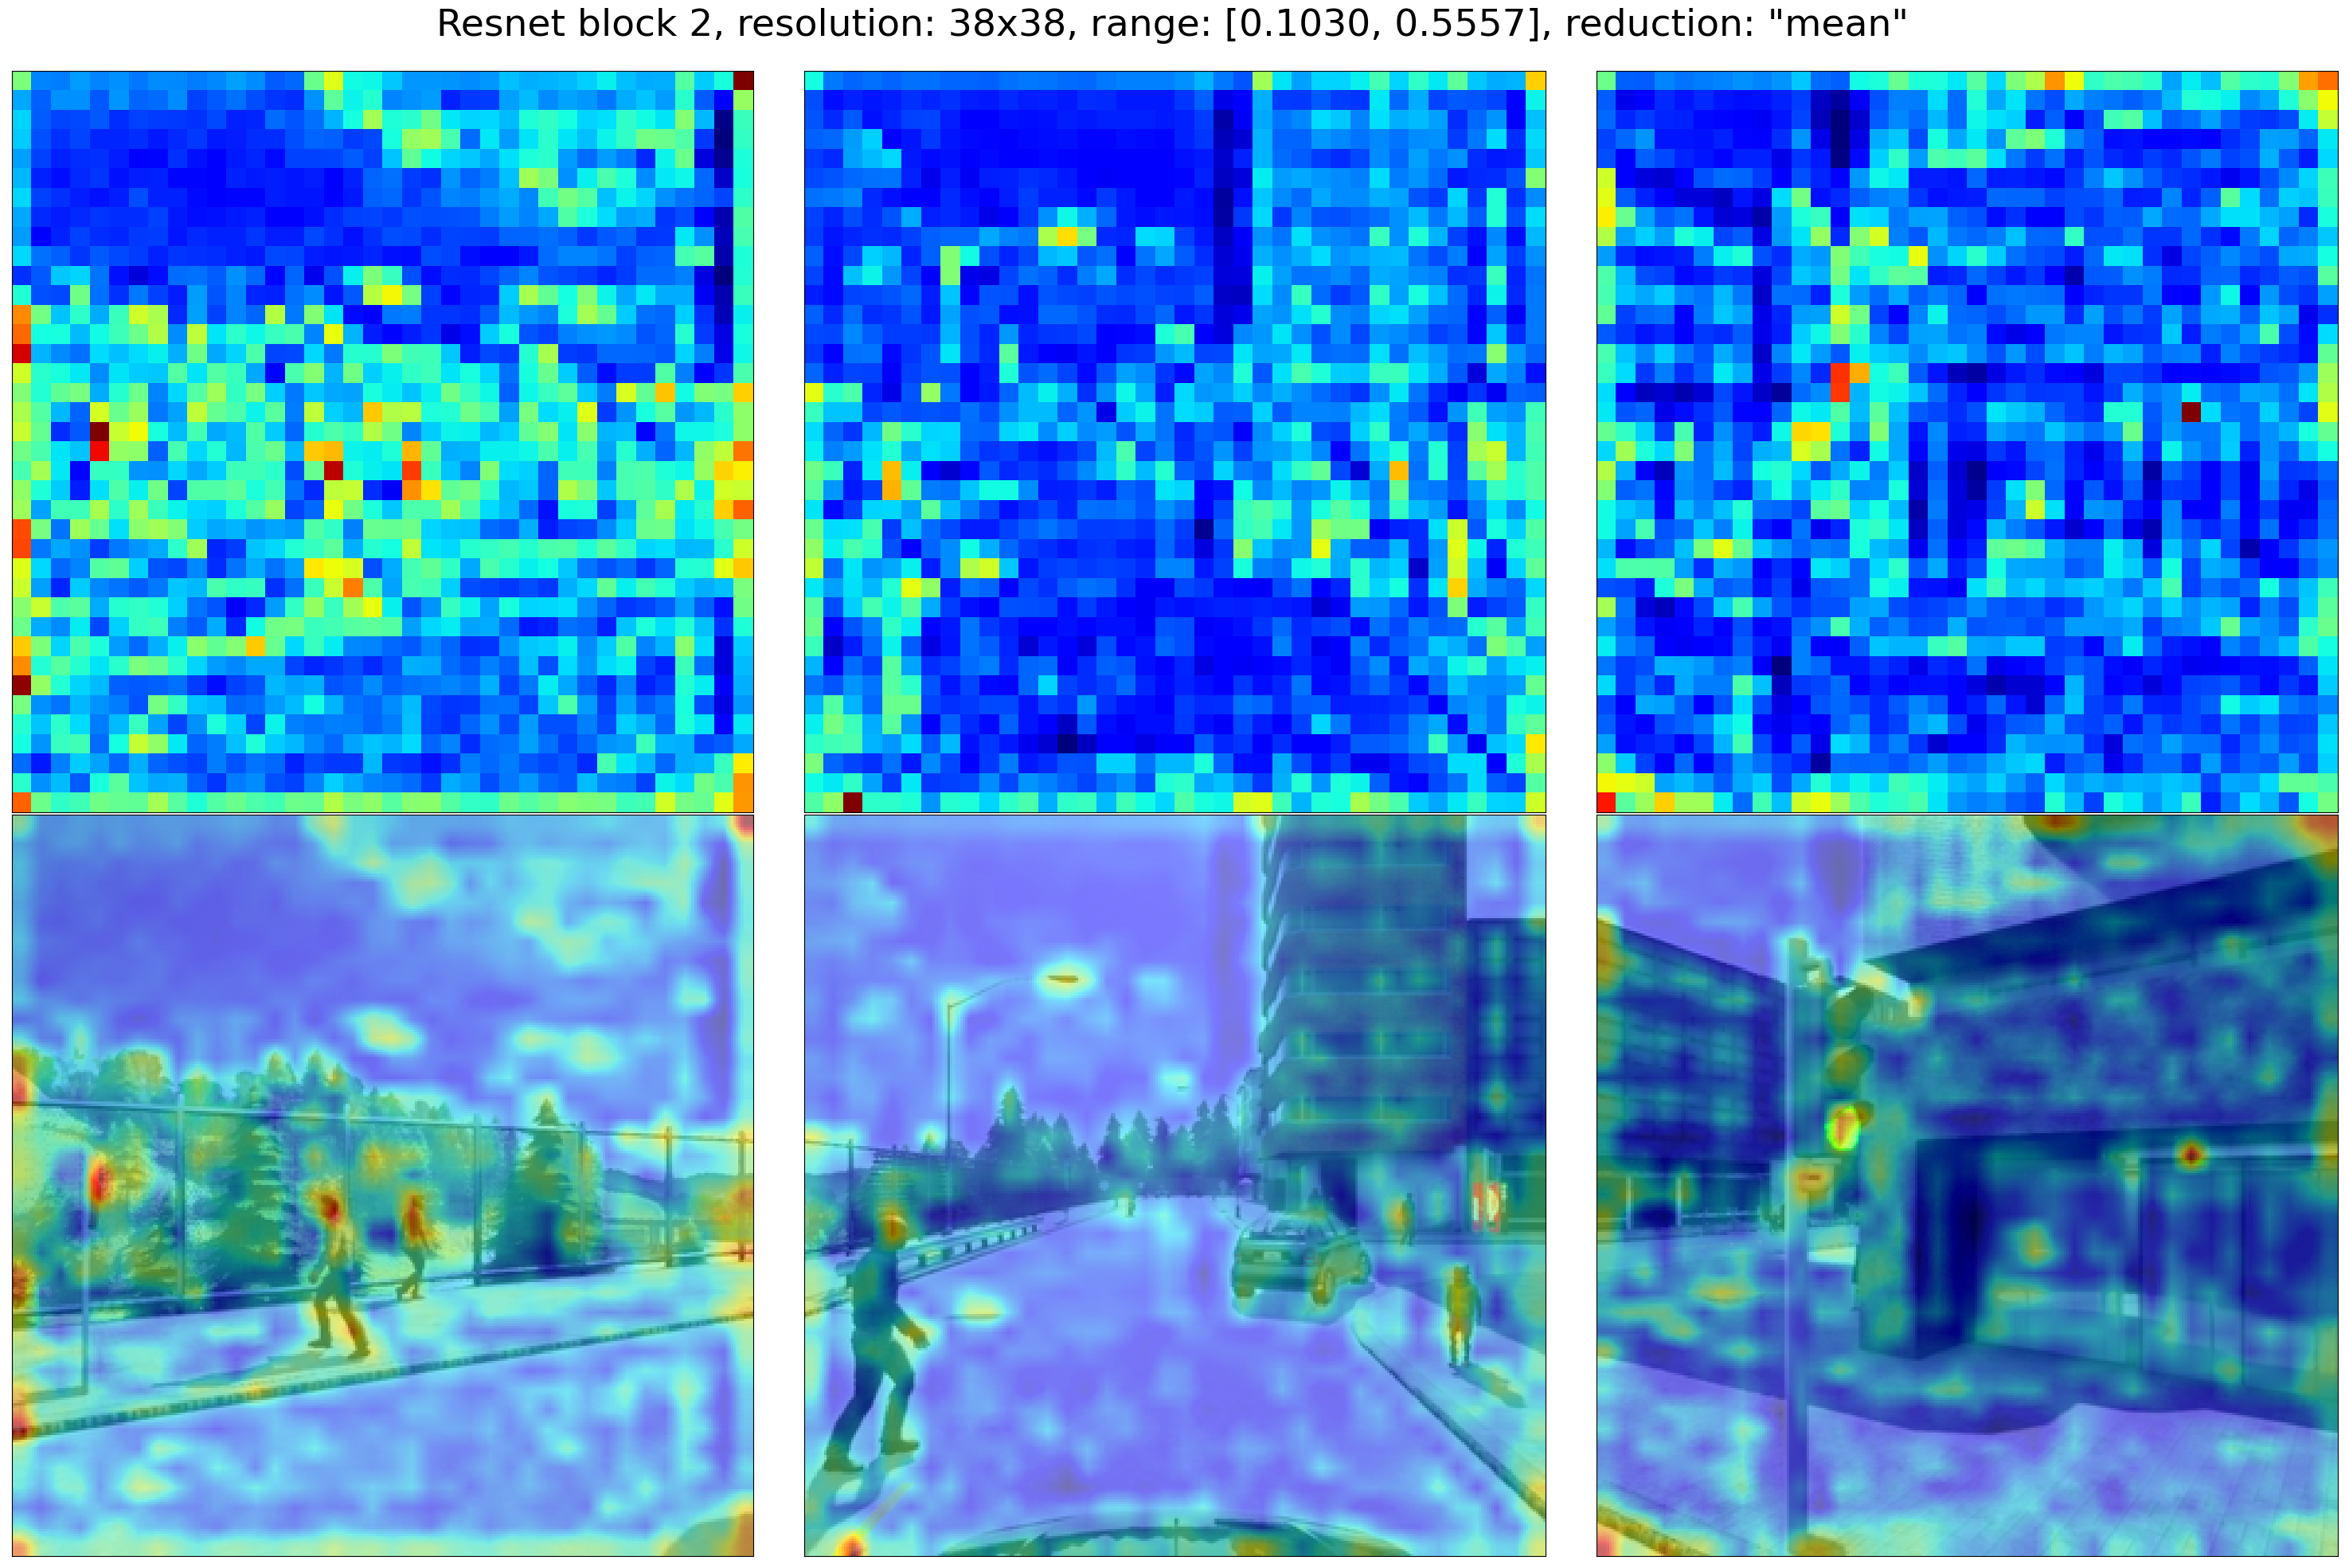

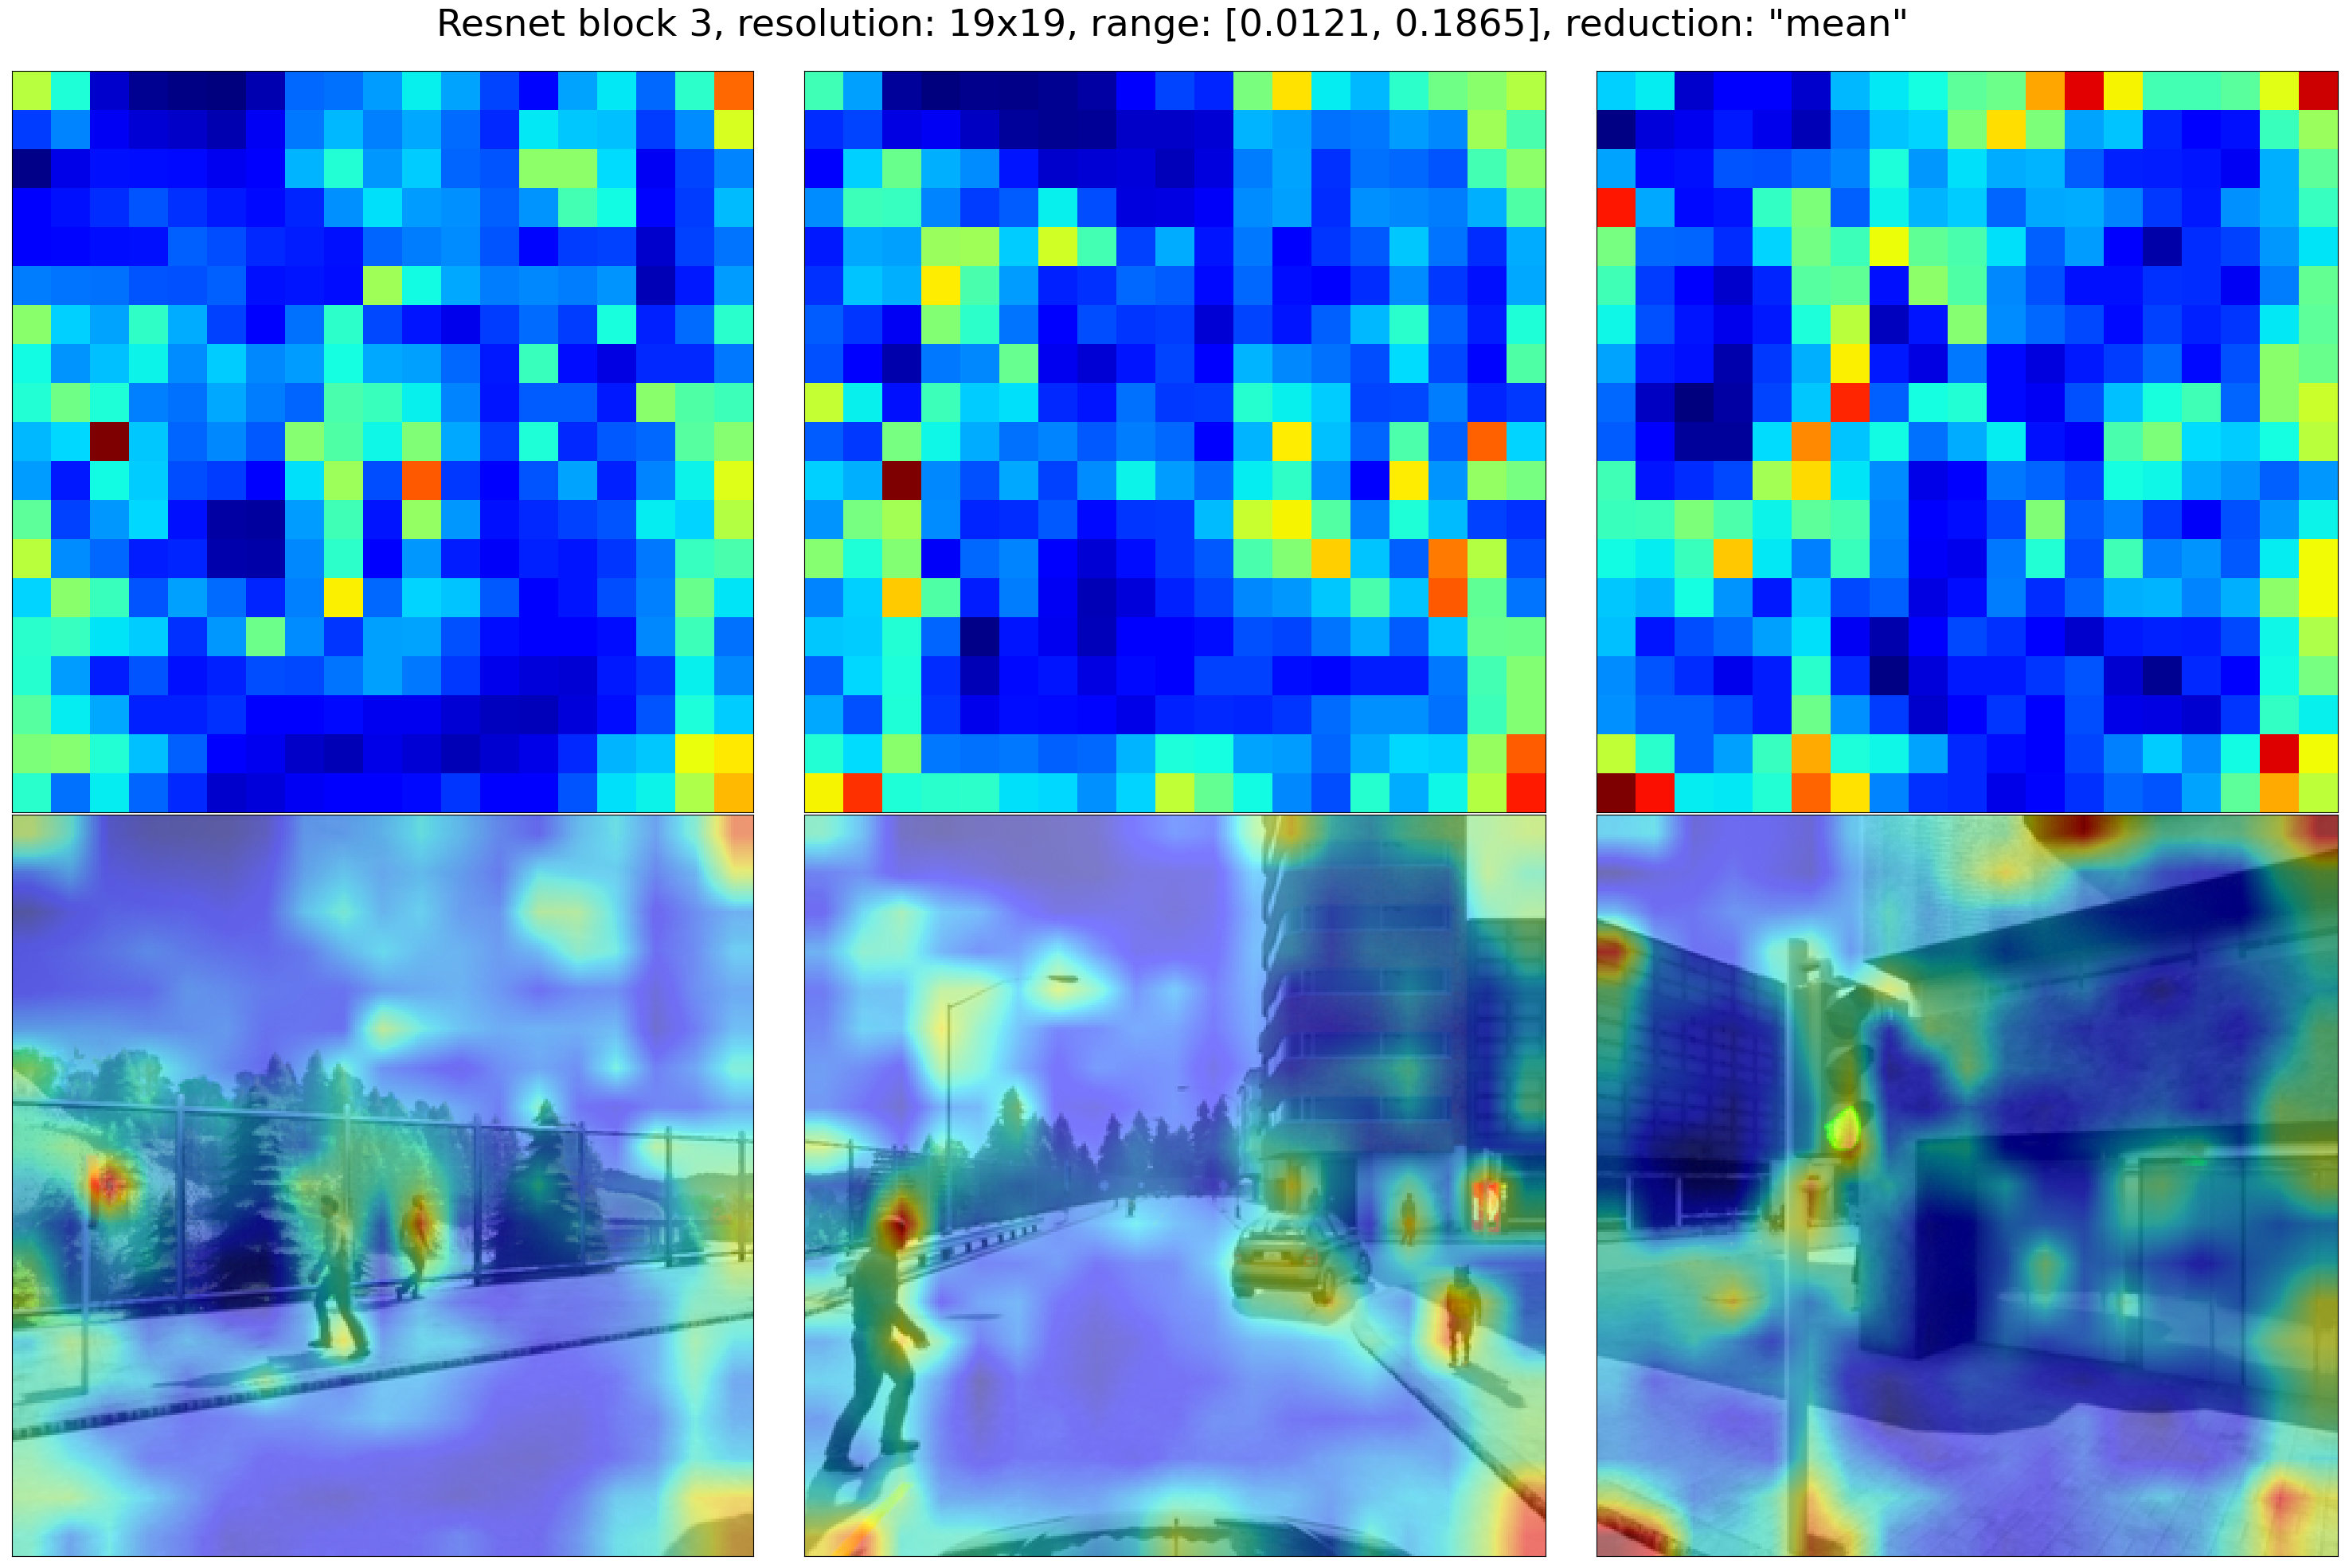

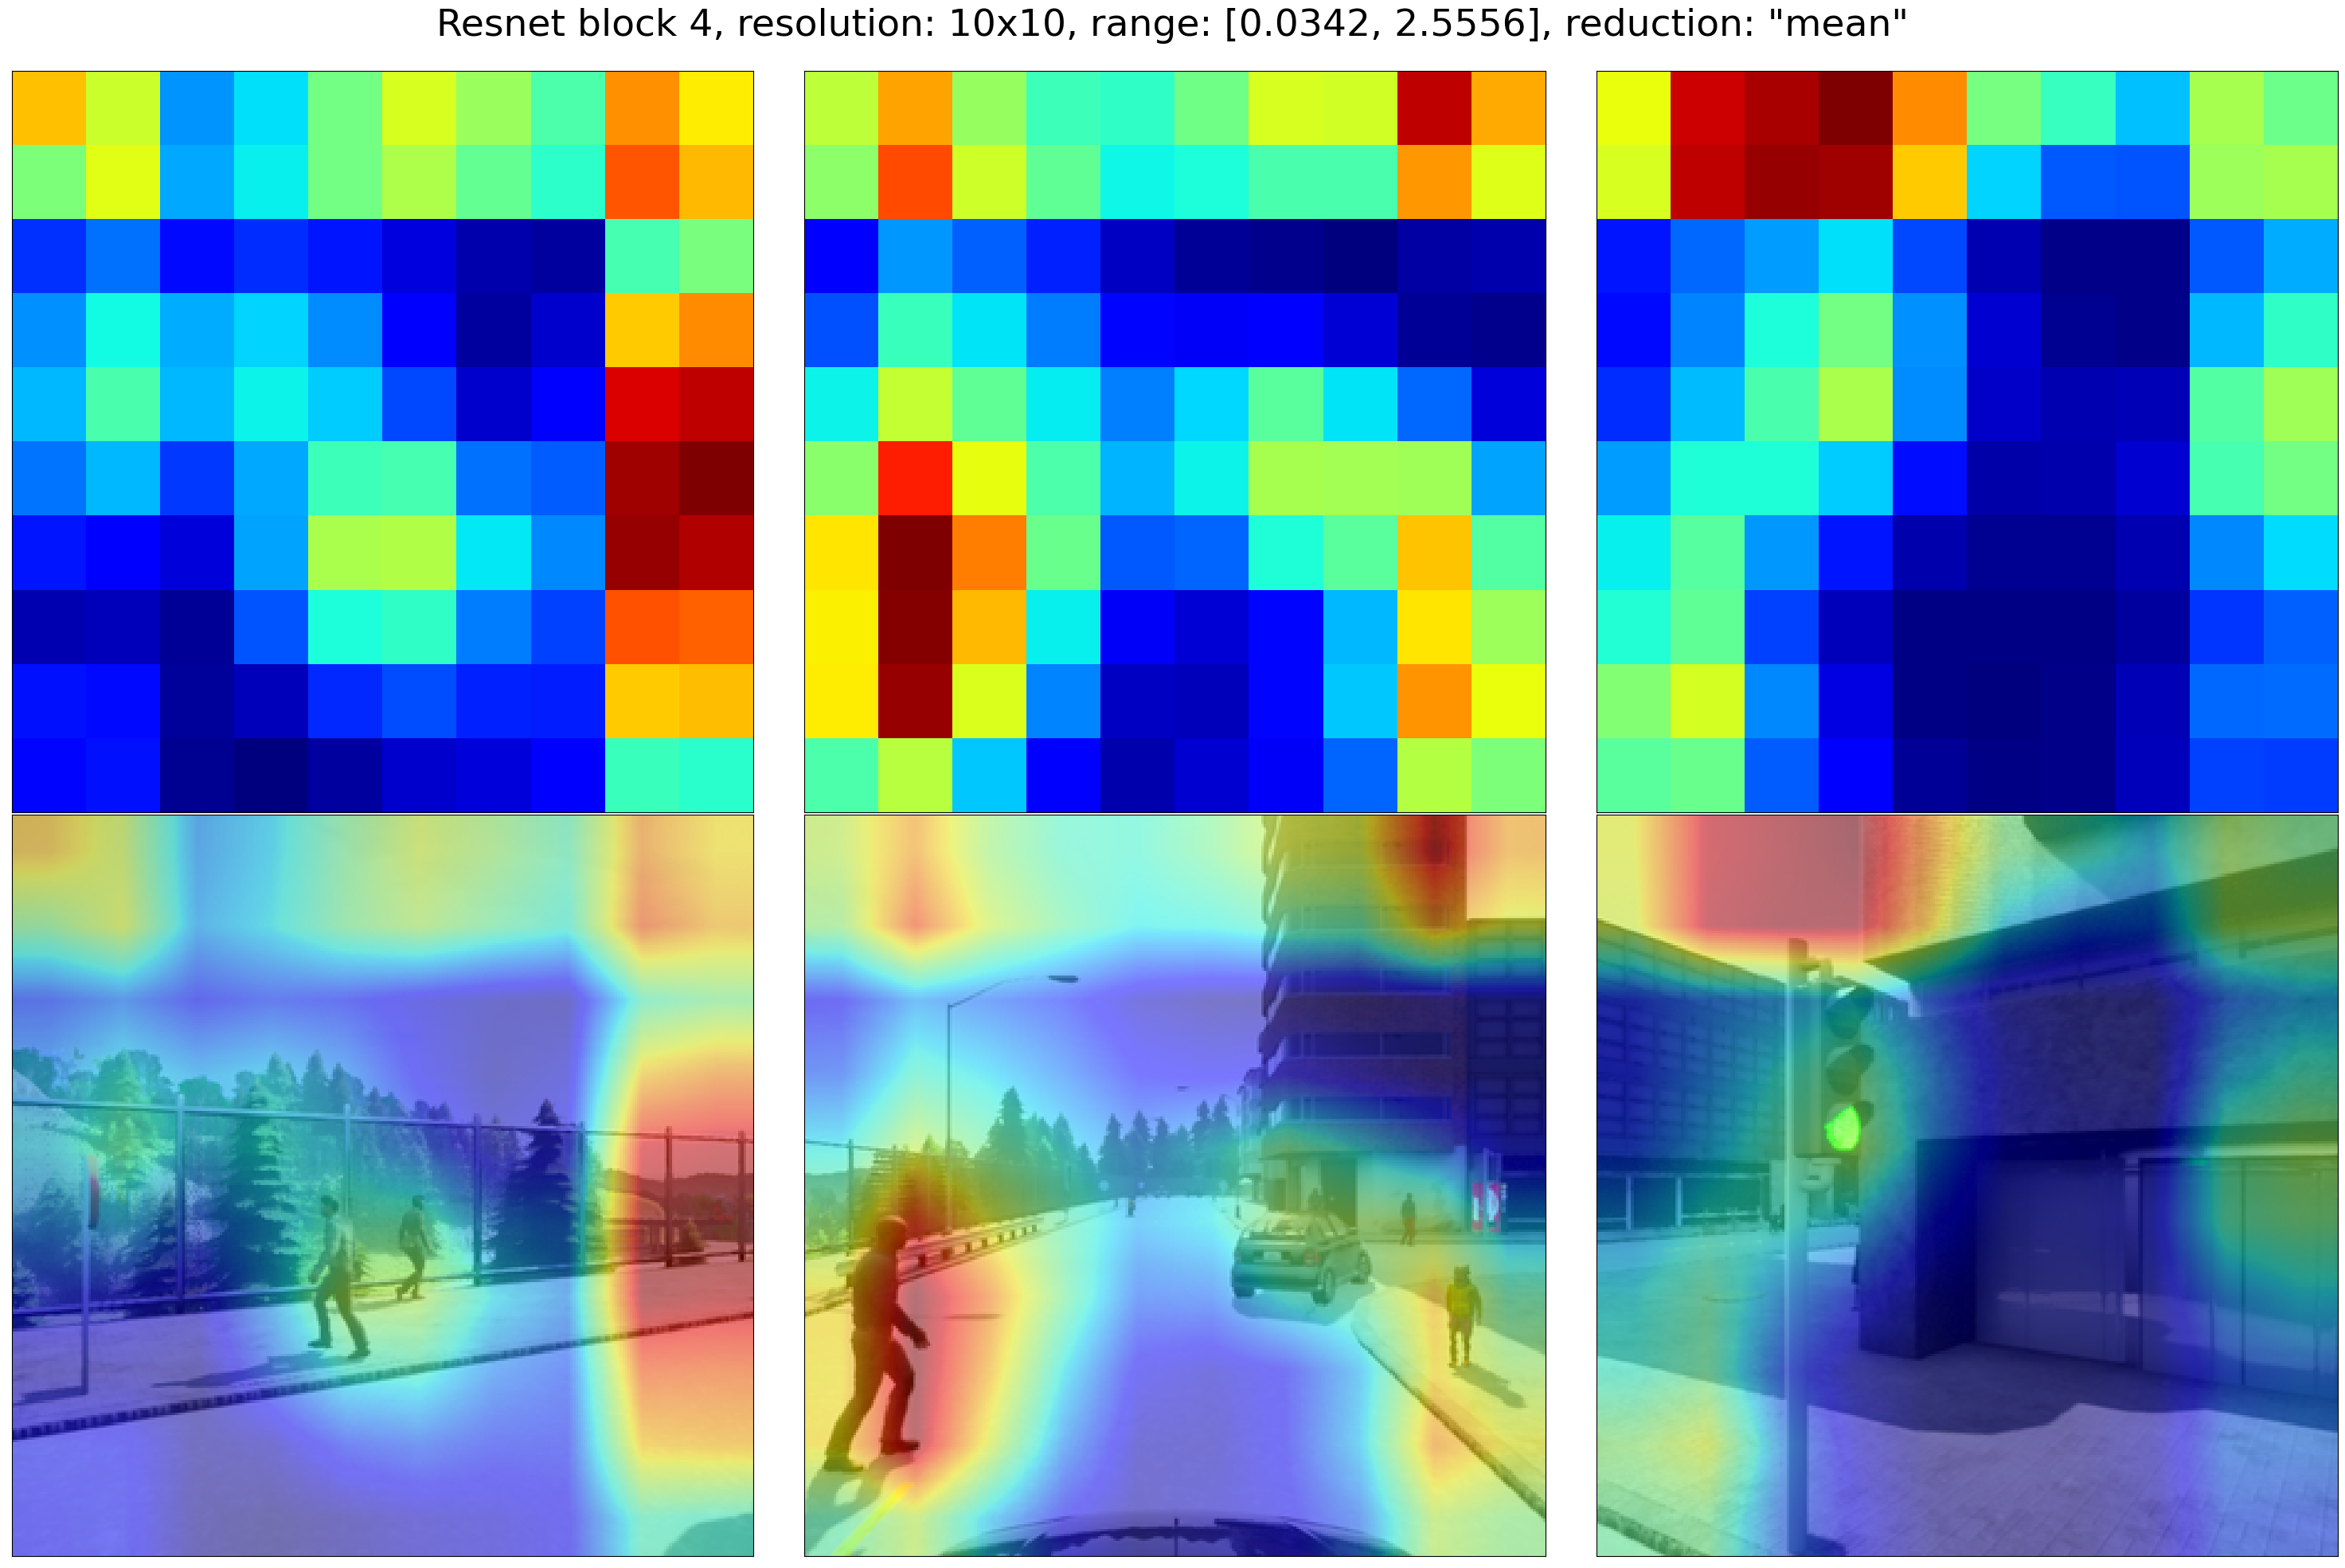

In [4]:
import torchvision.transforms.functional as TF
from einops import reduce
import cv2
import matplotlib.pyplot as plt

reduction = 'mean'

for idx, res in enumerate(resnet_inter):
    num_cameras = res.shape[0]
    # Average over the channels (dim=1)
    res = reduce(res, 'cam dim h w -> cam h w', reduction)
    
    # Plot the three cameras side by side
    fig, ax = plt.subplots(2, num_cameras, figsize=(10 * num_cameras, 20))
    fig.suptitle(f'Resnet block {idx}, resolution: {res.shape[-1]}x{res.shape[-1]}, range: [{res.min().item():.4f}, {res.max().item():.4f}], reduction: "{reduction}"', fontsize=34)

    for cam in range(num_cameras):
        ax[0, cam].imshow(res.detach().numpy()[cam], cmap='jet')
        ax[0, cam].set_xticks([])
        ax[0, cam].set_yticks([])

        img = src_images[cam][:3, :, :]
        img = TF.normalize(img, [-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.255])
        img = torch.clamp(img, 0, 1)

        res_up = cv2.resize(res.detach().numpy()[cam], (img.size(1), img.size(2)), interpolation=cv2.INTER_LINEAR)
        # res_up = TF.resize(res[cam], img.size(-1), antialias=True)
        ax[1, cam].imshow(img.detach().numpy().transpose(1, 2, 0))
        ax[1, cam].imshow(res_up, cmap='jet', alpha=0.5)
        ax[1, cam].set_xticks([])
        ax[1, cam].set_yticks([])


    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

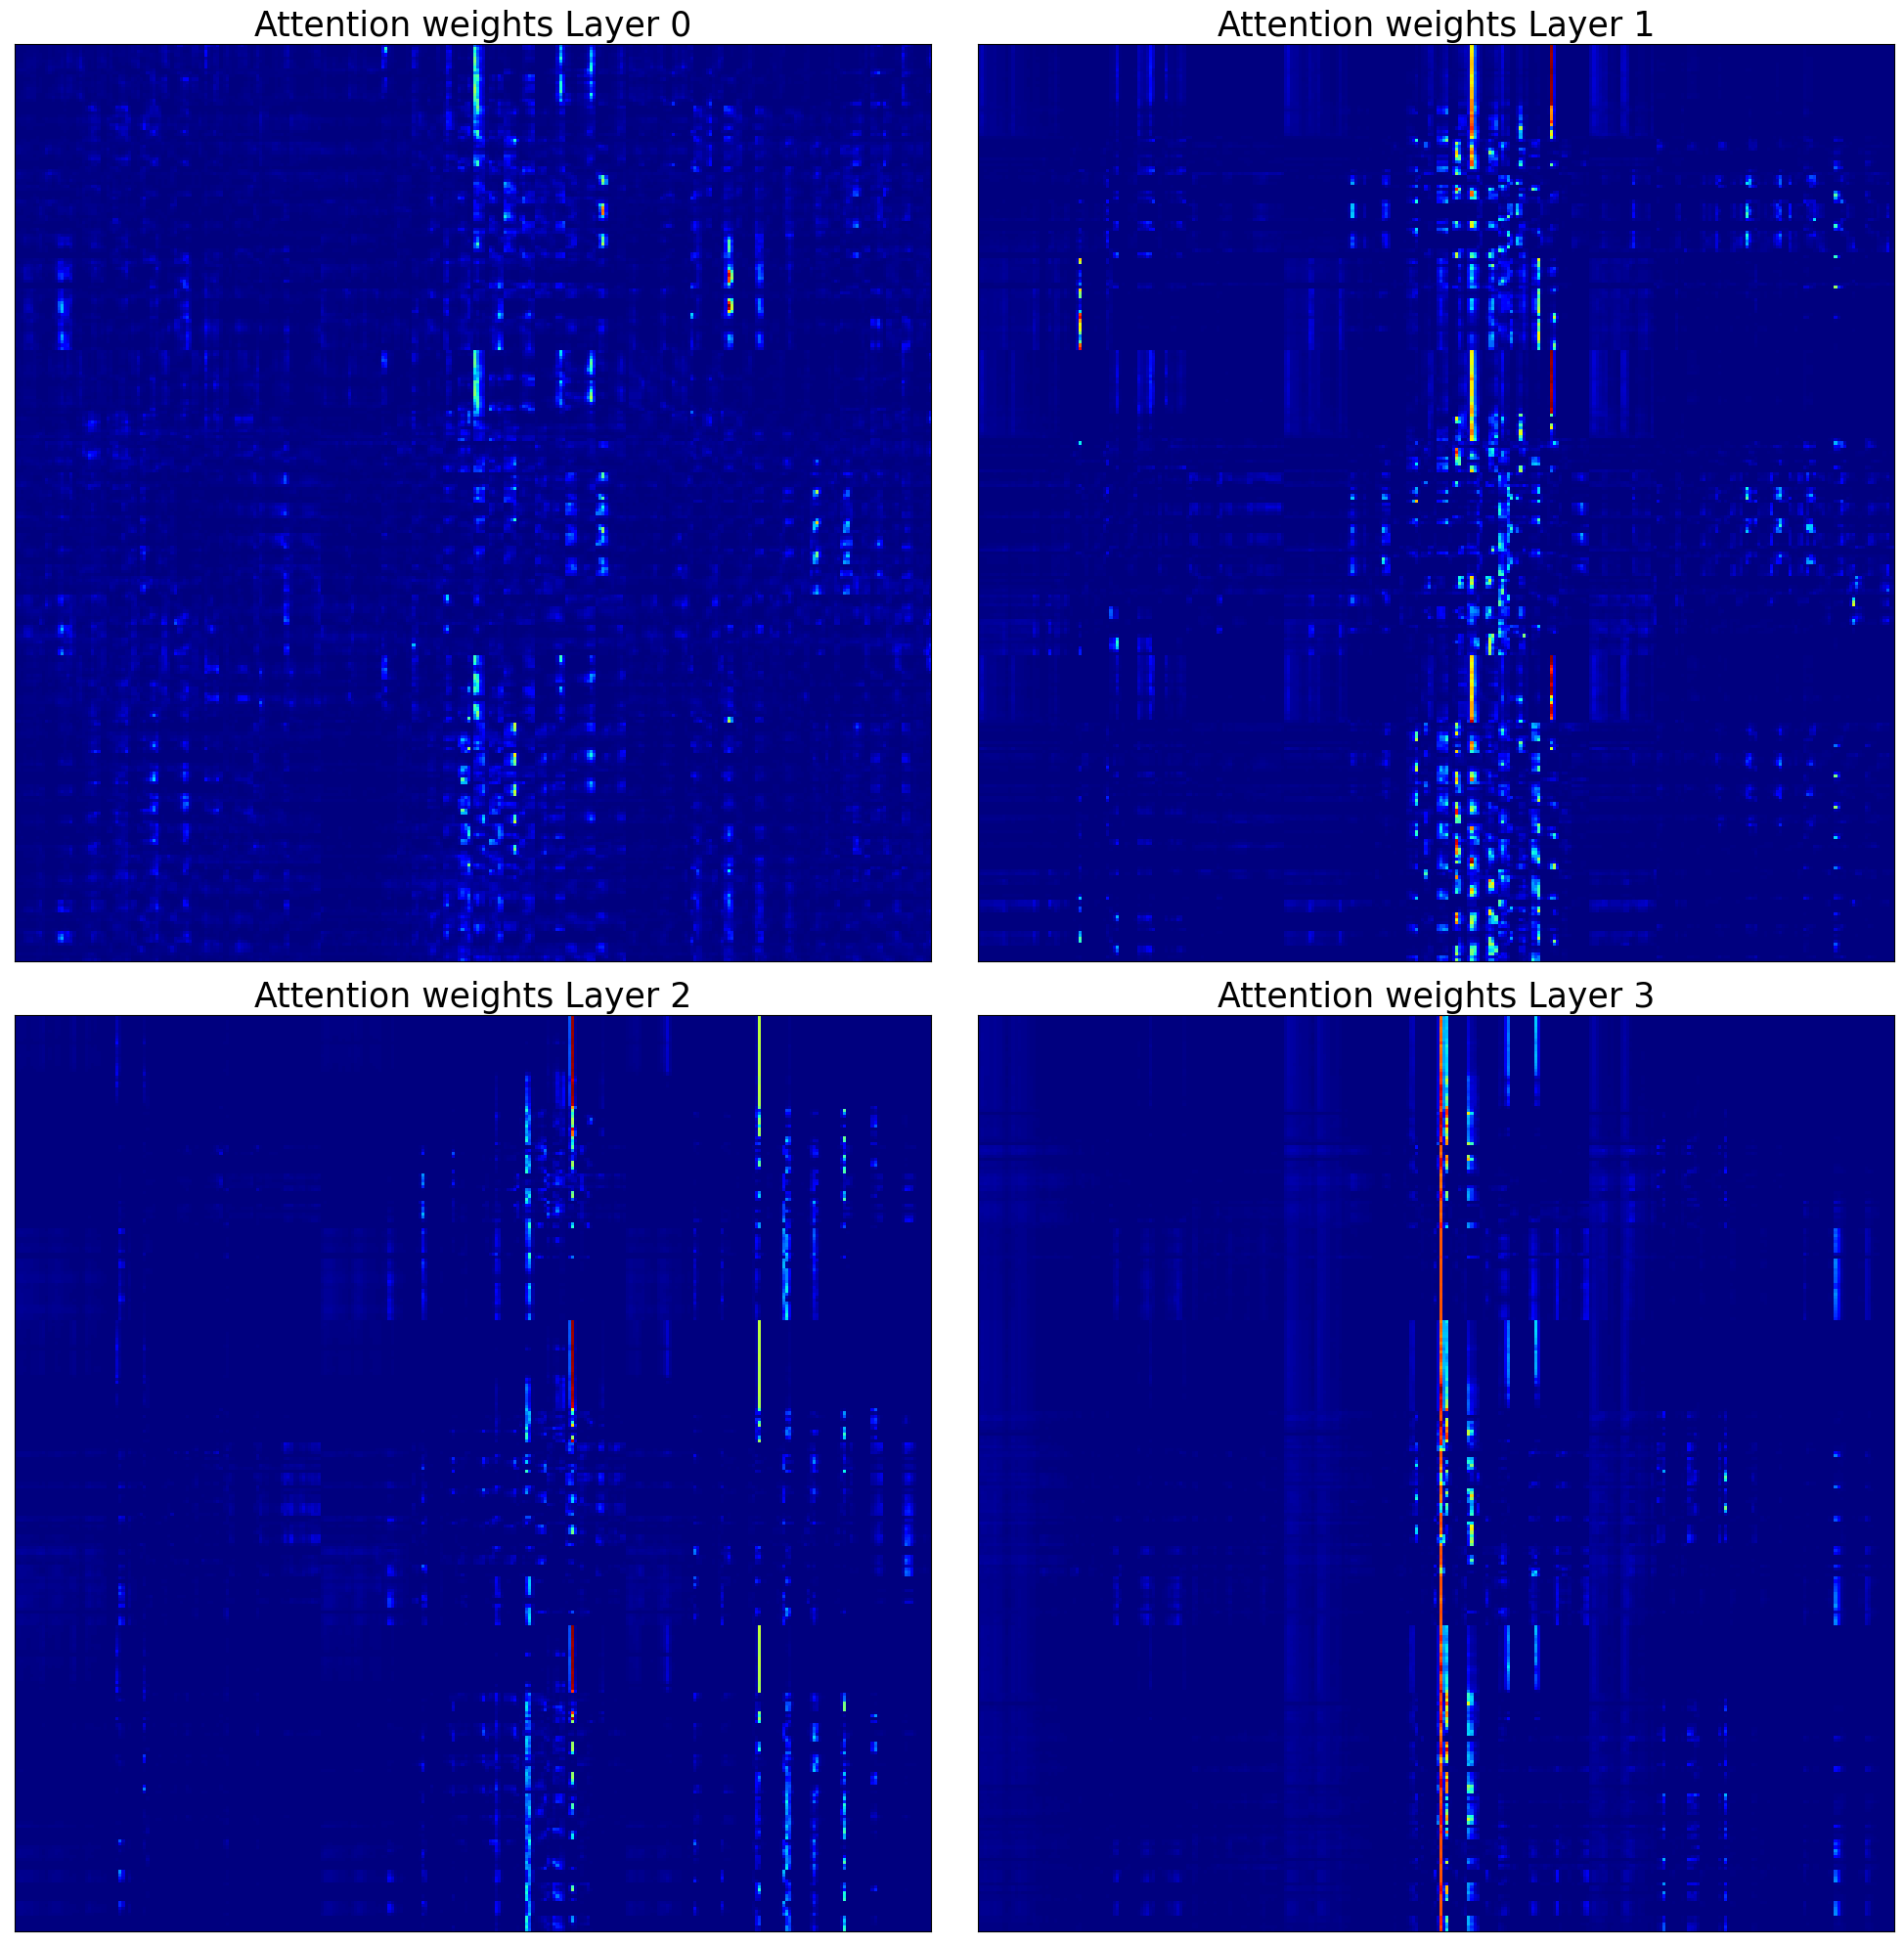

In [5]:
# attn_weights is a list of 4 elements, each a tensor of shape (1, 300, 300)
# Let's plot them
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for idx, attn in enumerate(attn_weights):
    # Set title
    ax[idx // 2, idx % 2].set_title(f'Attention weights Layer {idx}', fontsize=25)
    ax[idx // 2, idx % 2].imshow(attn.squeeze().detach().numpy(), cmap='jet')
    ax[idx // 2, idx % 2].set_xticks([])
    ax[idx // 2, idx % 2].set_yticks([])

    fig.tight_layout()
    # fig.subplots_adjust(top=0.94)
plt.show()

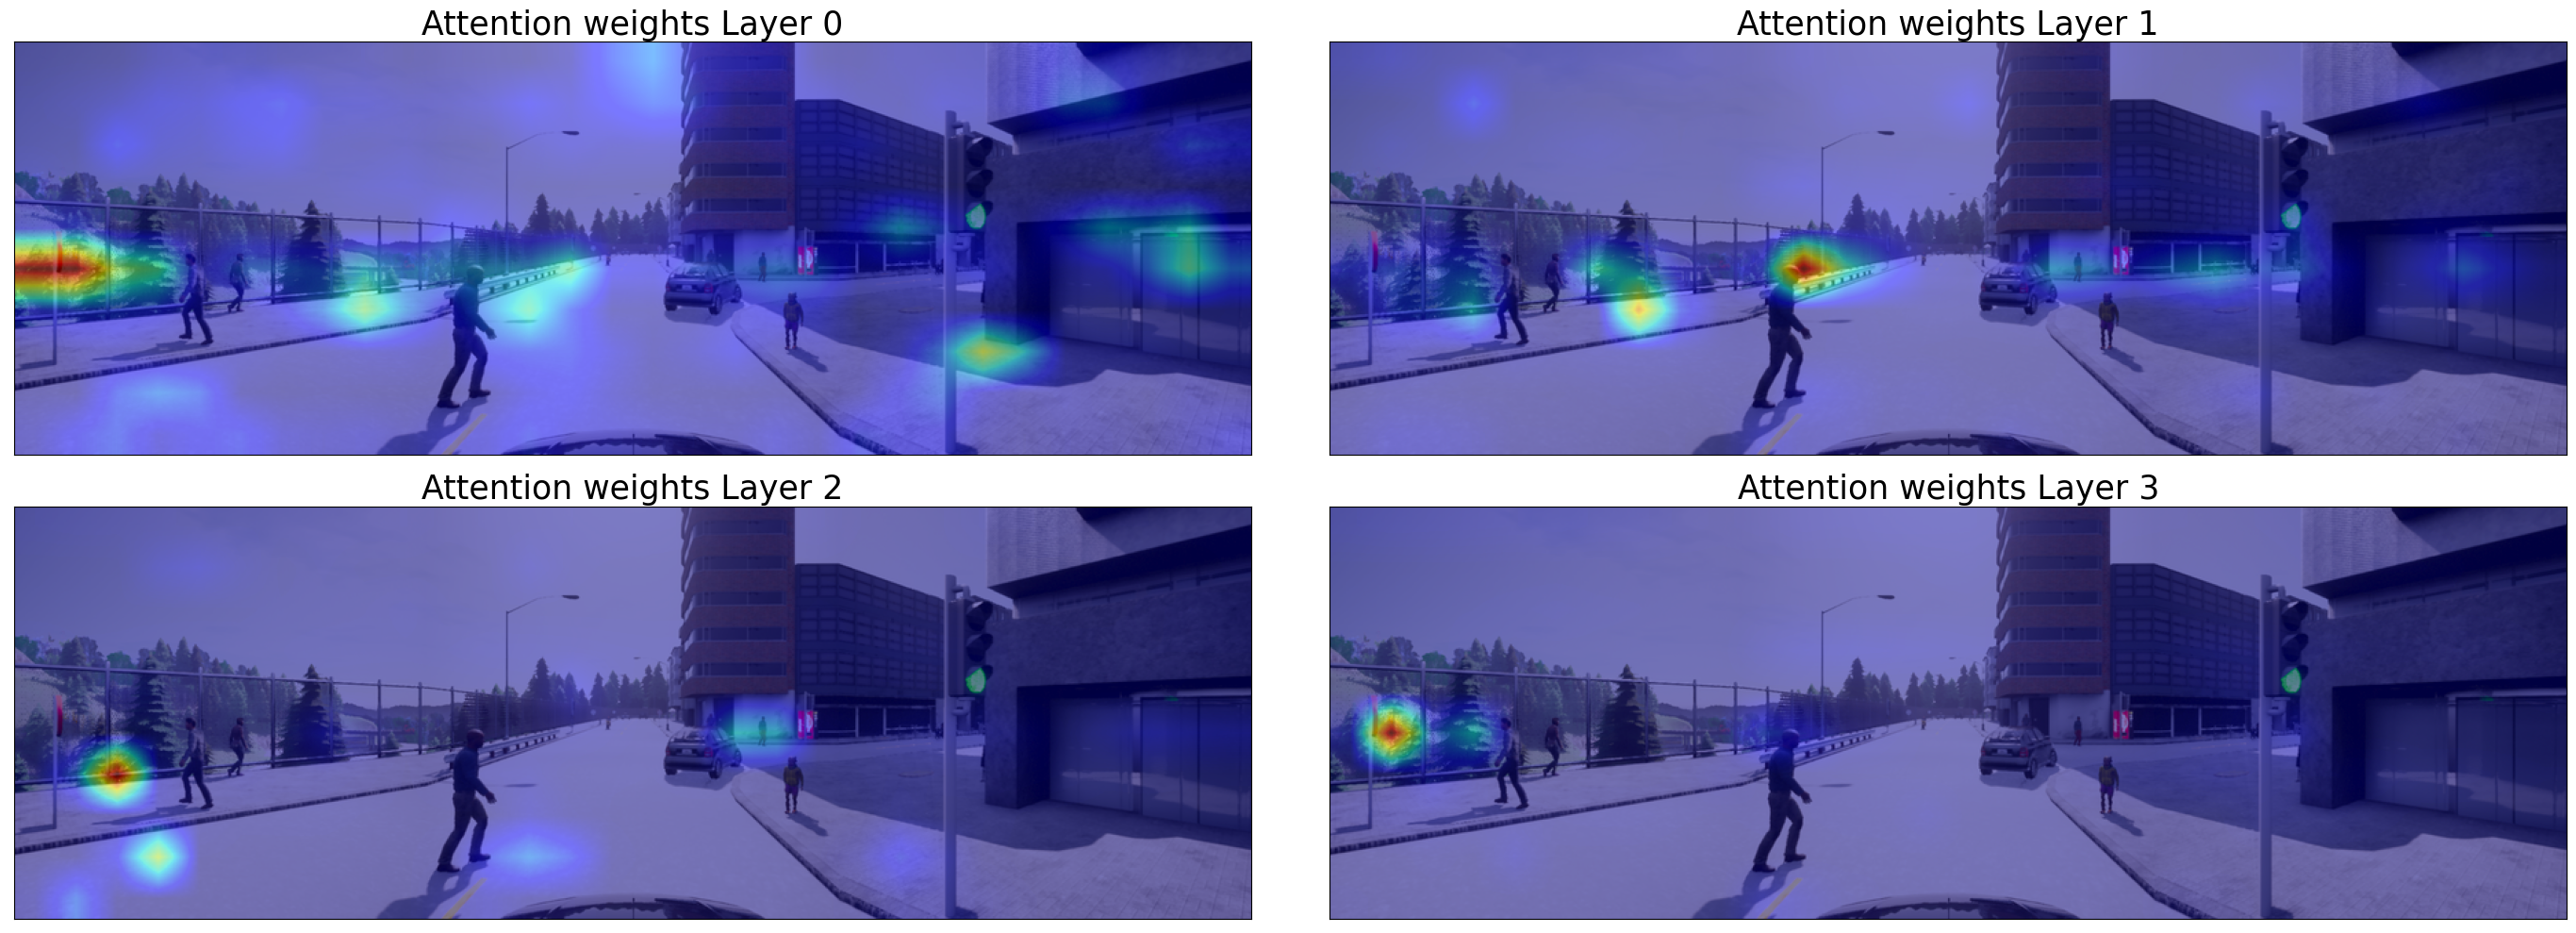

In [7]:
# Let's show them on top of the images
# First, concatenate horizontally the left, central, and right camera images
img_cat = torch.cat(src_images, dim=2)[:3, :, :]
img_cat = TF.normalize(img_cat, [-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.255])
img_cat = torch.clamp(img_cat, 0, 1)
img_cat = img_cat.cpu().numpy().transpose(1, 2, 0)

fig, ax = plt.subplots(2, 2, figsize=(30, 10))
for idx, attn in enumerate(attn_weights):
    # Set title
    ax[idx // 2, idx % 2].set_title(f'Attention weights Layer {idx}', fontsize=25)
    ax[idx // 2, idx % 2].imshow(img_cat)
    # Plot attention weights
    attn = attn.squeeze().mean(0).view(10, 30).detach().numpy()
    attn = cv2.resize(attn, (img_cat.shape[1], img_cat.shape[0]), interpolation=cv2.INTER_LINEAR)
    ax[idx // 2, idx % 2].imshow(attn, cmap='jet', alpha=0.5)
    ax[idx // 2, idx % 2].set_xticks([])
    ax[idx // 2, idx % 2].set_yticks([])

    fig.tight_layout()
    # fig.subplots_adjust(top=0.94)
plt.show()